Archivos:  
https://drive.google.com/file/d/1qyTUuMw8KIAJdpQvBTJGjkBW5EYooQqU/view?usp=sharing

https://drive.google.com/file/d/1jowsoePYsf1Fn6aaylJqbfTzUxrIJTza/view?usp=sharing

https://drive.google.com/file/d/1S9_8Ll7u0qnV_J6TPxpu9VA6ZkeW5_Qd/view?usp=sharing

https://drive.google.com/file/d/1LMqTQ0RltHZbHllS1YCIIlZ6UuszHkCD/view?usp=sharing

# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
import datetime

# data visualization
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns 
from pylab import rcParams

# statistics
from statsmodels.tsa.stattools import acf, adfuller

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

# machine learning: 
import xgboost as xgb
from xgboost.sklearn import XGBRegressor #

# prophet by Facebook
from fbprophet import Prophet

# mediciones de Error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Optimización de Hiperparámetros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


#sns.set(style="white", context="talk")
sns.set()
# Definición de Tipo, tamaño, color y ancho de las Fuentes para los títulos de los gráficos
title_font= {"family" : "Cambria",
             "size" : 18,
             "color" : "black",
             "weight" : "bold"}

plt.rcParams.update({'figure.figsize': (10,6), 'figure.dpi': 120})

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Vincular la cuenta de Googgle Drive donde están almacenados los archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

data_2019 = pd.read_csv('/content/drive/MyDrive/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/drive/MyDrive/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/content/drive/MyDrive/flujo-vehicular-2017.csv', sep =',')

In [4]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [5]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [6]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [7]:
data_2019.shape

(812153, 10)

In [8]:
data_2018.shape

(1375908, 10)

In [9]:
data_2017.shape

(1372645, 10)

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [10]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [11]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [12]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [13]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dataset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [14]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [15]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [16]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [17]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [18]:
# Verifico la existencia de nulos en el dataset
dataset.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

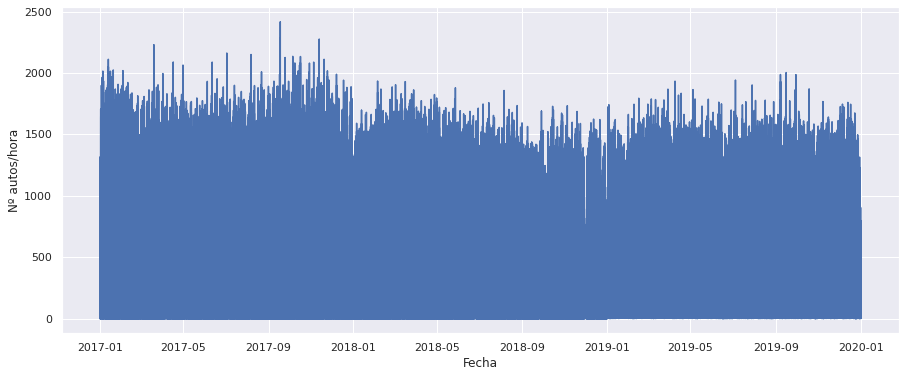

In [19]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Fecha')
plt.ylabel('Nº autos/hora')
plt.show()

In [20]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una mejor visualización de los datos
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


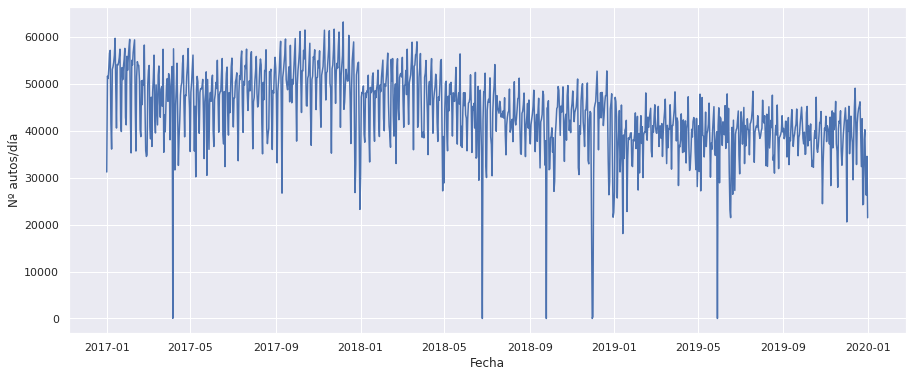

In [21]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Fecha')
plt.ylabel('Nº autos/día')
plt.show()

En el primer gráfico observamos las serie de datos representada en su frecuencia original de muestreo que en este caso es hora. En dicho gráfico se puede observar sectores blancos que me están indicando la ausencia de información o bien valores atípicos.  Para lograr una mejor visualización modifique el periodo de tiempo a dias. En este segundo gráfico se puede observar que hay dias en los cuales tenemos valores atípicos. Más adelante realizaré su tratamiento.

In [22]:
# Cambio el indice del dataset por el campo fecha.
dataset_n = dataset.set_index('fecha')
dataset_n.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               ...
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 21:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 22:00:00',
               '2019-12-31 22:00:00', '2019-12-31 22:00:00',
               '2019-12-31 23:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='fecha', length=238869, freq=None)

 **ANÁLISIS EXPLORATORIO DE DATOS**

findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


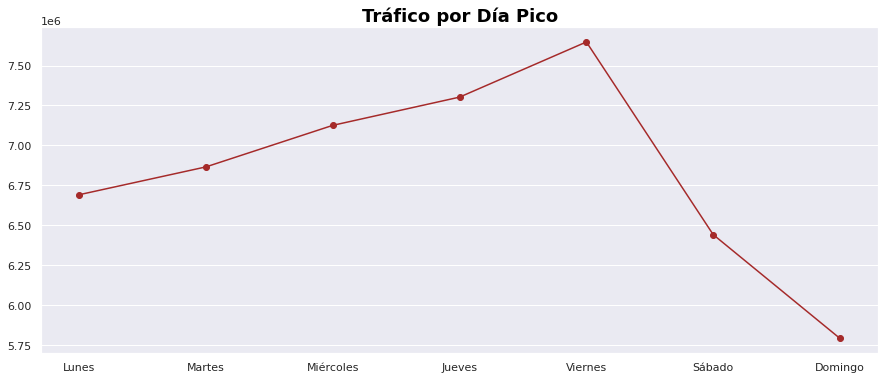

In [23]:
plt.figure(figsize = (15,6))
by_weekday = dataset_n.groupby(dataset_n.index.dayofweek).sum()
by_weekday.index = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.plot(by_weekday, color='brown', marker='o')
plt.title('Tráfico por Día Pico', fontdict=title_font)
plt.grid(axis='x')
plt.show()

Con respecto al **tráfico diario** se puede observar que los días de la semana con mayor tráfico son los Viernes mientras que los días de menor tráfico son los días Domingo.

<Figure size 1080x432 with 0 Axes>

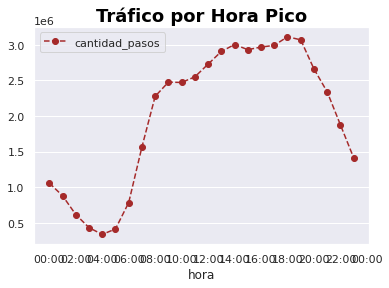

In [24]:
plt.figure(figsize = (15,6))
by_time = dataset_n.groupby(dataset_n.index.time).sum()
hourly_ticks = 2 * 60 * 60 *  np.arange(13)
by_time.plot(xticks=hourly_ticks, style='--o', color='brown')
plt.title('Tráfico por Hora Pico', fontdict=title_font)
plt.xlabel('hora')
plt.grid(axis='x')
plt.show();

**COMENTARIO:** En el gráfico superior se observa el tráfico por hora pico que esta dado entre la franja horaria de las **8hs y 19hs**. Comienza a crecer a las 6 de la mañana, se mantiene oscilante durante el día y empieza a decrecer a partir de las 18hs. Esto efectivamente concuerda con el inicio y fin de la jornada laboral.

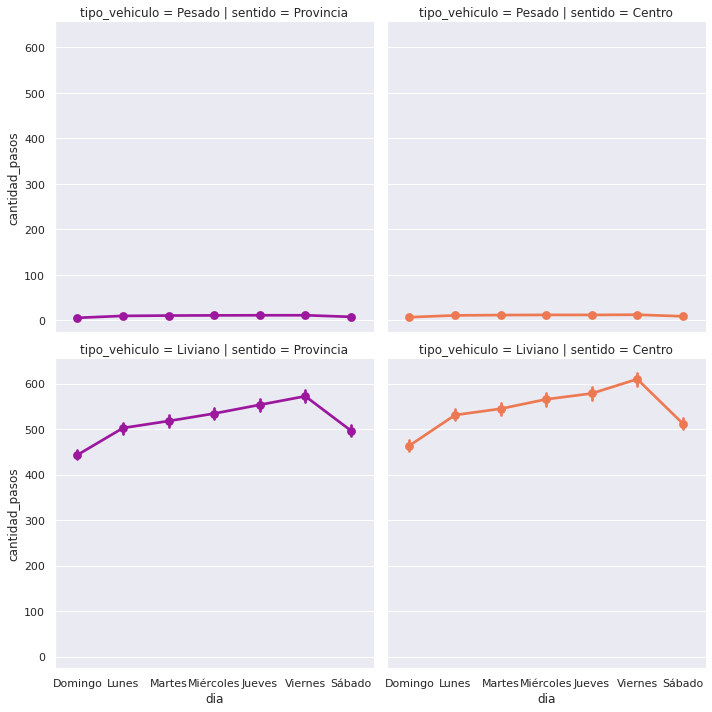

In [25]:
sns.factorplot(data = dataset_n, x = 'dia', y = 'cantidad_pasos', 
               col = 'sentido', 
               palette = 'plasma',
               hue = 'sentido',
               row = 'tipo_vehiculo', 
               color = 'c');

**COMENTARIO:** Lo que puede verse es que el transito de los vehiculos pesados es mucho menor que el de los livianos, independientemente del sentido que analicemos. Tambien puede observarse que el flujo vehicular aumenta desde el domingo al viernes y luego decrece.

# Estudio los Componentes del Dataset

Voy a utilizar la librería de Statsmodels, la cual posee una función que descompone a la serie de datos en sus componentes:

*   Estacionalidad
*   Tendencia
*   Ruido



Para una mejor visulaizacion de los datos voy a usar el dataset "diario" que habia generado mas arriba:

In [26]:
diario.head()

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


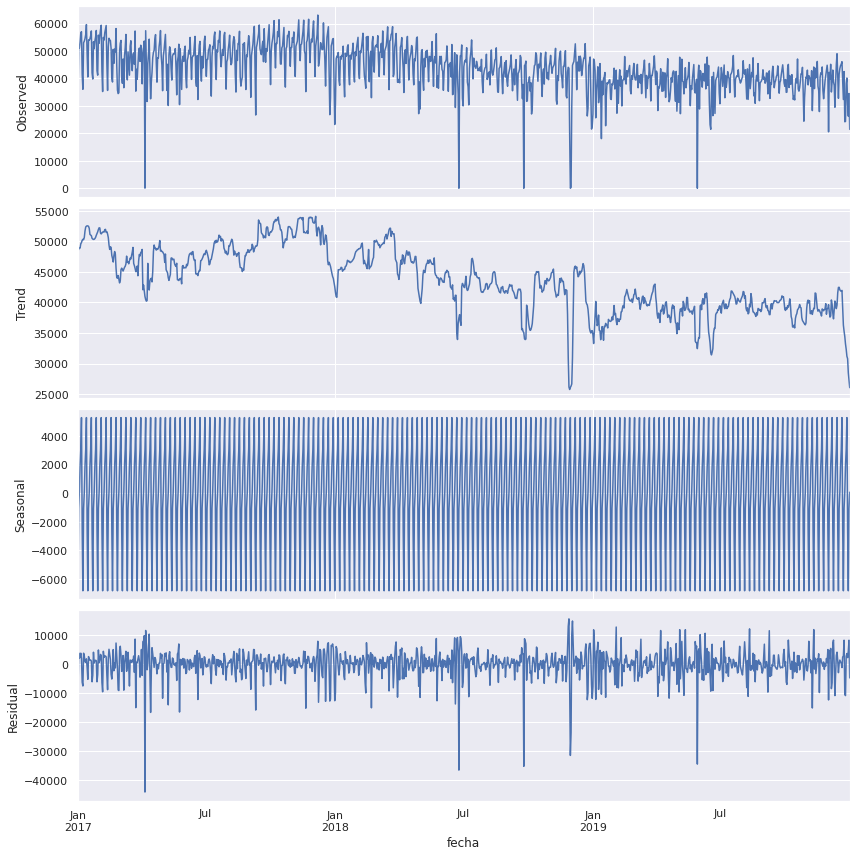

In [27]:
#Voy a descomponer el dataset resampleado por día para estudiar sus componentes.
result = seasonal_decompose(diario.cantidad_pasos, extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.grid(axis='x')
plt.show();

**COMENTARIO:** La función de descomposición nos presenta un gráfico por cada componenete de la serie. En cuanto a la tendencia, la cual nos indica la dirección global que está tomando la serie, se puede observar que es **decreciente** y **no es estacionaria**, puesto que no se mantiene recta. De todas maneras, en los graficos que hicimos mas arriba (para ver dias y horas pico) vimos una estacionalidad de tipo semanal, diaria y horaria. En resumen, la serie no es estacionaria en la media pero variando o modificando la visualización de la misma se puede observar que por día o por semana encontramos patrones que me ayudaran a entender y estudiar mejor los datos. Lo cual podria tambien ayudarnos a realizar predicciones mas acertadas de su comportamiento. 

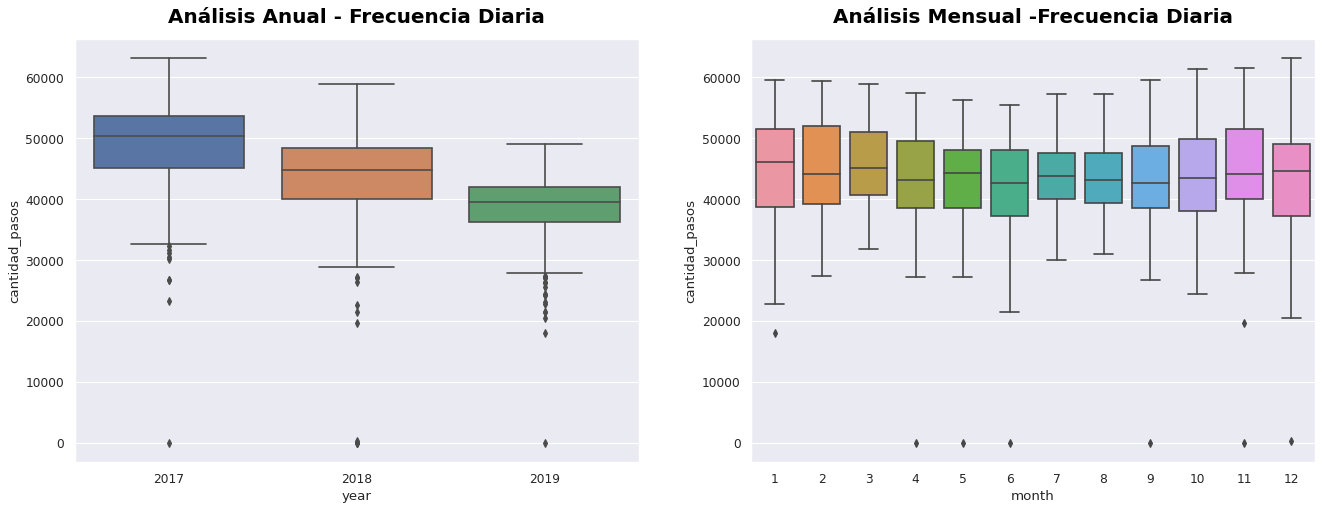

In [28]:
# Visualizo los datos Por Año y Mes 
diario['year'] = diario.index.year
diario['month'] = diario.index.month
years = diario['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='cantidad_pasos', data=diario, ax=axes[0])
sns.boxplot(x='month', y='cantidad_pasos', data=diario)

# Set Title
axes[0].set_title('Análisis Anual - Frecuencia Diaria', fontdict=title_font, pad=15 ); 
axes[1].set_title('Análisis Mensual -Frecuencia Diaria', fontdict=title_font, pad=15 )
plt.show();

**COMENTARIOS:** Viendo el gráfico del **análisis anual** de los datos, podemos observar que el flujo diario de vehículos mostro una tendencia decresciente con los años. Esto podria estar en relación con la disminución en el uso de "efectivo" para realizar los pagos. Se observan outliers en todos los años, los cuales seran trabajados a continuación. Pasando al **análisis mensual** del flujo vehicular, se observa una leve caida hacia el mes de julio, lo cual coincidiría con el receso de invierno. Los valores mas elevados estan presentes en los meses de diciembre y enero, podría deberse a las fiestas navideñas y vacaciones de verano. Tambien aparecen outliers que trabajaré mas adelante.

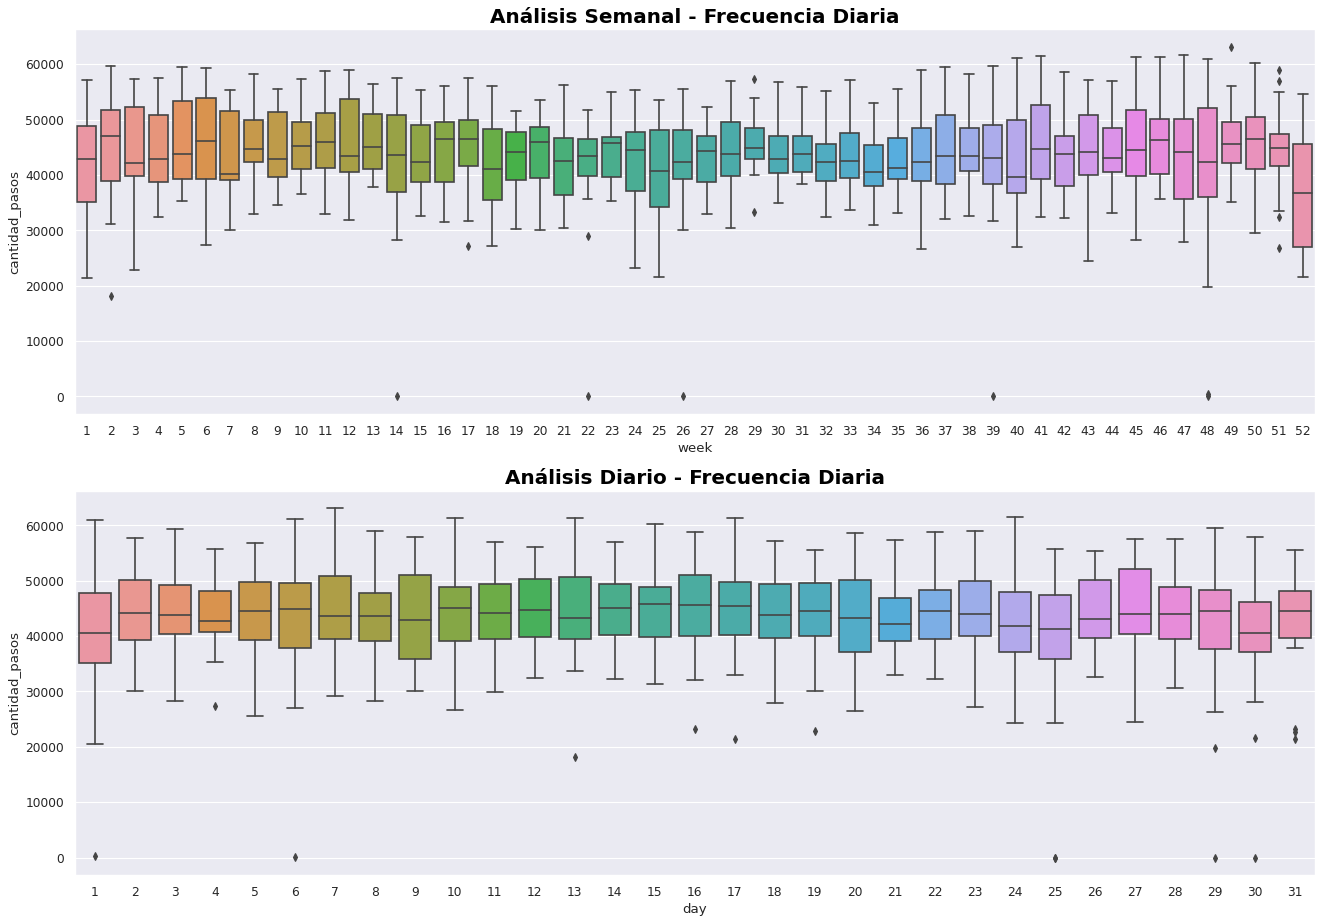

In [29]:
# Visulizando los datos por Semanas y Días 
diario['week'] = diario.index.week
diario['day'] = diario.index.day
diario['month']= diario.index.month

# Draw Plot
fig, axes = plt.subplots(2, 1, figsize=(20,7*2), dpi= 80)
sns.boxplot(x='week', y='cantidad_pasos', data=diario, ax=axes[0])
sns.boxplot(x='day', y='cantidad_pasos', data=diario)

# Set Title
axes[0].set_title('Análisis Semanal - Frecuencia Diaria', fontdict=title_font ); 
axes[1].set_title('Análisis Diario - Frecuencia Diaria', fontdict=title_font)
plt.show();

**COMENTARIO:** tanto en el **análisis semanal** como en el **diario** del flujo vehicular, se observan fluctuaciones que ponen en evidencia el movimiento vehicular que se repite semana a semana. En ambos casos aparecen outliers que deberan ser tratados.

**TRATAMIENTO DE VALORES ATÍPICOS:** 

In [30]:
#Función para eliminar outliers, tiene en cueta el rango intercuartílico: 
def elimino_outliers(dataset,var):
    '''
    Dado un dataset y un feature 
    devuelve la mascara(filtro) 
    con los datos a eliminar en 
    ese feature del dataset aplicando
    el rango intercuantílico.
    '''
    
    q25,q75 = np.percentile(dataset[var], [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = np.logical_or(dataset[var] < minimo, dataset[var] > maximo)
    return mascara_outliers

In [31]:
dataset_outliers = elimino_outliers(diario,'cantidad_pasos')
dataset_outliers.sum()

16

In [32]:
# Imprimo los outliers detectados
diario[dataset_outliers]

,cantidad_pasos,year,month,week,day
fecha,,,,,
2017-04-06,40,2017,4,14,6
2017-12-31,23229,2017,12,52,31
2018-06-25,0,2018,6,26,25
2018-09-25,0,2018,9,39,25
2018-11-29,19728,2018,11,48,29
2018-11-30,0,2018,11,48,30
2018-12-01,350,2018,12,48,1
2018-12-30,21559,2018,12,52,30
2018-12-31,22599,2018,12,1,31


**COMENTARIO:**  buscando que ocurrio los dias que no hubo tráfico vehicular, se encontró que corresponden a días de paro general, otro correspode al día de la cumbre del G20 lo que justifica el cierre del peaje o bien el no paso de vehículos. Por otro lado, los días con mayores valores corresponden a fecha tales como fin de año donde mucha gente viaja a otros lugares para pasar las fiestas o por comienzo de vacaciones.

Ahora voy a reemplazar los outliers por NAN para luego aplicar la función de pandas *interpolate* para cubrir dichos valores. El metodo elegido es *time* el cual trabaja con datos diarios en un intervalo de tiempo y de esta manera completa los datos faltantes y normaliza la serie de datos.

In [33]:
# Reemplazo los outliers por NAN y aplico la interpolacion a la serie
diario[dataset_outliers] = np.nan
print(diario.isnull().sum())
diario = diario.interpolate(method='time')
print(diario.isnull().sum())

cantidad_pasos    16
year              16
month             16
week              16
day               16
dtype: int64
cantidad_pasos    0
year              0
month             0
week              0
day               0
dtype: int64


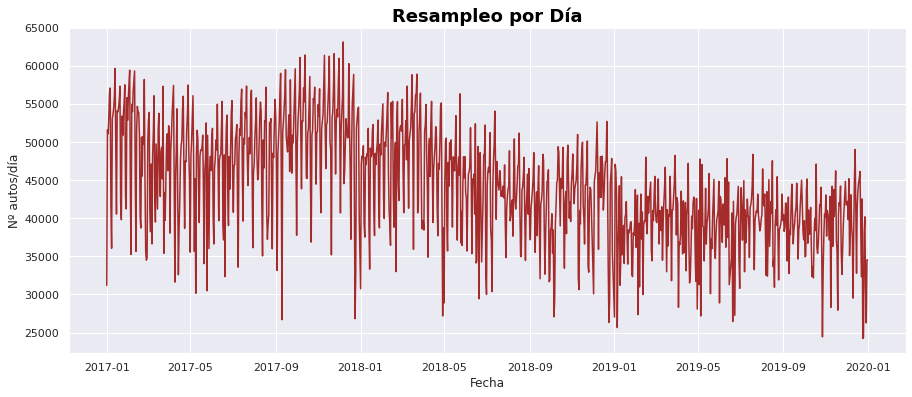

In [34]:
# Visulizo nuevamente los datos pero sin los outliers
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos,color='brown')
plt.xlabel('Fecha')
plt.ylabel('Nº autos/día')
plt.title('Resampleo por Día', fontdict=title_font)
plt.show();

**COMENTARIO:** se sigue observando una tendencia decresciente con los años, tal lo señalado anteriormente. Dentro de cada mes se observan fluctuaciones en el transito vehicular.

**ANÁLISIS DE AUTOCORRELACIÓN CON LA LIBRERÍA STADMODEL:** El estudio de la autocorrelación nos da una idea de la realcion que hay con un período y el anteriro, lo cual sería si el futuro se parece al pasado.

Como estoy trabajando con la frecuencia DIARIA determino un resago de 180 días

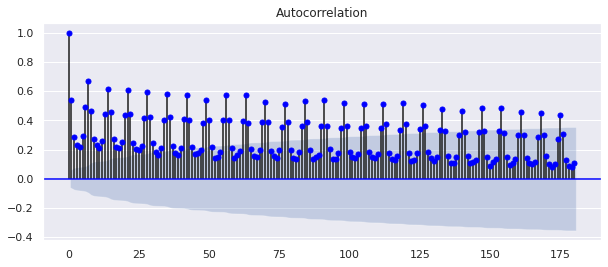

In [35]:
# Para predecir todo mi dataset 
nlags = 180 
plt.figure(figsize = (10, 4))
plot_acf(diario.cantidad_pasos, lags =nlags, ax = plt.gca(), color = 'blue')
plt.grid(axis='x')
plt.show();

**COMENTARIO:** puede observarse que un ciclo se repite cada 7 dias, con lo cual esto confirma la estacionalidad semanal.

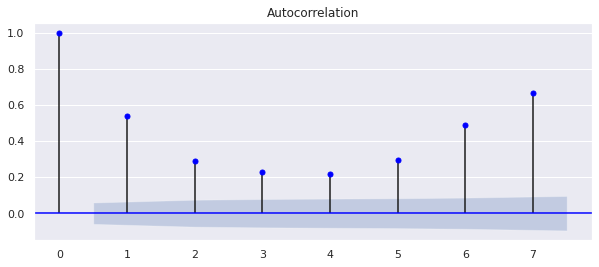

In [36]:
# Para analizar mi dataset aplicaré una ventana a 7 días
nlags = 7
plt.figure(figsize = (10, 4))
plot_acf(diario.cantidad_pasos, lags =nlags, ax = plt.gca(), color = 'blue')
plt.grid(axis='x')
plt.show();

**COMENTARIO:** cada pico que se eleva por encima o por debajo de las imagen sombreada se considera estadísticamente significativo, es decir diferente de cero. Si un pico es significativamente diferente de cero, esto es evidencia de autocorrelación.

La autocorrelación es simplemente la correlación de una serie con sus propios retrasos. Si una serie está significativamente autocorrelacionada, eso significa que los valores previos de la serie (lags) pueden ser útiles para predecir el valor actual.

In [37]:
diario.head()

,cantidad_pasos,year,month,week,day
fecha,,,,,
2017-01-01,31183.0,2017.0,1.0,52.0,1.0
2017-01-02,51568.0,2017.0,1.0,1.0,2.0
2017-01-03,51093.0,2017.0,1.0,1.0,3.0
2017-01-04,53332.0,2017.0,1.0,1.0,4.0
2017-01-05,56486.0,2017.0,1.0,1.0,5.0


**Predicción a Futuro**

**Predicción del último trimestre del 2019**

En el caso de las series de tiempo para realizar una predicción a futuro, la porción de testeo a utilizar va a ser siempre los datos más actuales. Existen dos maneras o esquemas de validación uno es el de ventana deslizante (One-Stpe Prediction) y la otra el de encadenamiento hacia adelante (Multi-Step Prediction) yo aplicaré la primera.
Debo definir una ventana (lag) con la cual entrenaré mi modelo. Elijo como ventana 365 días ya que considero que con esa información el modelo podra aprender mejor y así arrojará predicciones más certeras.

ONE-STEP PREDICTION

In [38]:
senial = diario.cantidad_pasos

In [39]:
senial.head()

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Freq: D, Name: cantidad_pasos, dtype: float64

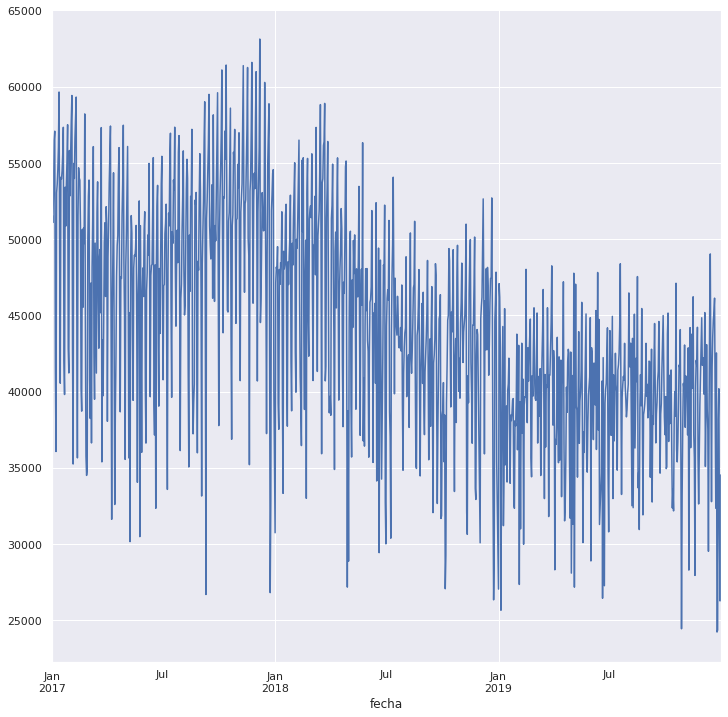

In [40]:
senial.plot()

In [41]:
# Mi ventana con la cual entrenaré mi modelo.Defino cuántos valores hacia atrás tomo para predecir el valor siguiente.
look_back = 365

In [42]:
#Creamos los X e y con ceros para luego llenar con los datos. 
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(729, 365) (729,)


In [43]:
#Llenamos los X y los y
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [44]:
print(X)

[[31183.         51568.         51093.         ... 54556.
  39969.         35352.        ]
 [51568.         51093.         53332.         ... 39969.
  35352.         30735.        ]
 [51093.         53332.         56486.         ... 35352.
  30735.         47130.        ]
 ...
 [47832.         35446.         32643.33333333 ... 24349.
  38168.         40182.        ]
 [35446.         32643.33333333 29840.66666667 ... 38168.
  40182.         30681.        ]
 [32643.33333333 29840.66666667 27038.         ... 40182.
  30681.         26259.        ]]


In [45]:
print(y)

[30735.         47130.         48162.         47953.
 49505.         39235.         37522.         48010.
 47033.         48454.         48229.         51792.
 38943.         33319.         49201.         48048.
 48340.         51548.         52287.         41208.
 37727.         48508.         47019.         48876.
 49963.         52881.         41907.         38733.
 49726.         48296.         51377.         53306.
 55008.         42606.         39956.         49983.
 49407.         51323.         53707.         56494.
 46189.         40941.         39217.         36454.
 55174.         50497.         55336.         43231.
 38824.         47717.         49936.         32992.
 52997.         55294.         44712.         42318.
 51311.         51972.         52184.         51412.
 55596.         46572.         40721.         49620.
 49692.         52810.         47659.         57329.
 48079.         41317.         50217.         51112.
 51868.         54717.         58825.         

In [46]:
# Definimos nuestros datos de Train y Test 
N_train = (365*2) + (364-92) - look_back # cantidad de instancias que vamos a usar para entrenar.Son 2 años y 9 meses( 637 días)
N_test = 92  #cantidad de puntos que vamos a usar para evaluar (3 meses -- 92 días)
N_total = N_train + N_test
print(N_train)
print(N_test)
length_total = N_train + N_test + look_back

print (length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

637
92
1094
(637, 365) (637,)
(92, 365) (92,)


In [47]:
# Defino el modelo con los valores por defecto, es decir, sin la definición de ningún hiperparametro.
xr = xgb.XGBRegressor()


In [48]:
# Entreno el modelo
xr.fit(X_train,y_train)

[13:20:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [49]:
# Predigo 
y_pred = xr.predict(X)
y_train_pred = xr.predict(X_train)
y_test_pred = xr.predict(X_test)

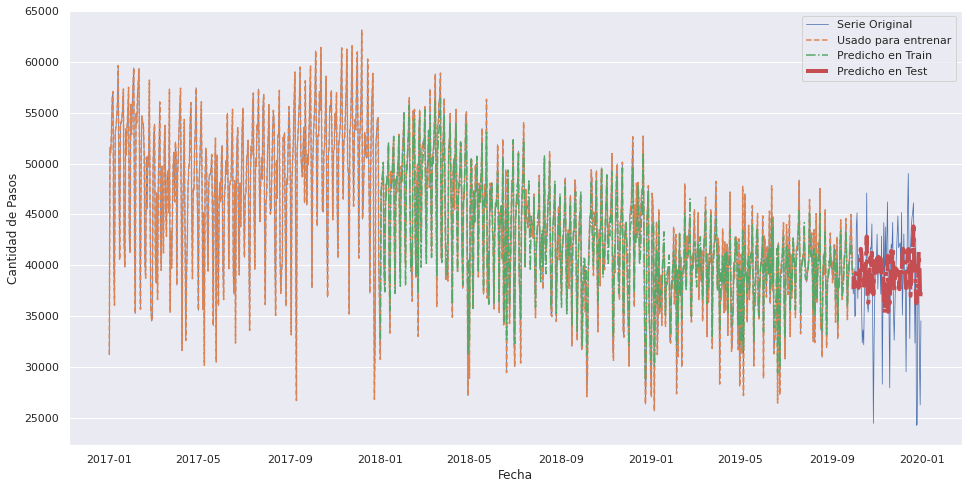

In [50]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test.
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.grid(axis='x')
plt.show();

In [51]:
# Analizo el error mediante el calculo el RMSE en train y test
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

RMSE en Train: 1715.3052803437422
RMSE en Test: 4628.880641021857


**COMENTARIO:** viendo el RMSE tengo una diferencia de 4600 vehículos por pasada, lo que parecería es que el modelo tiene sobreajuste ya que el RMSE del train es considerablemente mas bajo.

Este modelo va a ser mi modelo brenchmark.

Ahora voy a **optimizar los hiperparametros del XGboost** ya que la predicción (brenchmark) la realize con los valores por defecto. Para ello utilizaré el **randomsearchCV** de manera de lograr los mejores hiperparémetros y ver si entrenando nuevamente el modelo con los hiperparametros obtenidos obtengo una mejor predicción.

In [52]:
# base parameters (lo dejo como texto porque ya encontre los mejores parametros asi no o vuelve a correr)
#params = {'max_depth': range (2, 20, 2), 'min_child_weight': [4],'n_estimators': range(150,250,350),'colsample_bytree': [0.05,0.1,0.3,0.5,1],'learning_rate': [0.5, 0.1, 0.01, 0.05]}

#search_xpar = RandomizedSearchCV(xr, params, n_jobs=10, cv=10, verbose=True, scoring='neg_mean_squared_error')

#search_xpar.fit(X_train, y_train)

#print('Mejores Hiperparámetros: '+str(search_xpar.best_params_))
#print('Mejor Score:'+str(search_xpar.best_score_)+'\n')

In [53]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos 

xr_b = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=150, max_depth=2, learning_rate= 0.05,
                        min_child_weight=4,colsample_bytree=0.05, random_state=42)

# Entreno  el modelo 
xr_b.fit(X_train,y_train)

# Predigo 
y_pred = xr_b.predict(X)
y_train_pred = xr_b.predict(X_train)
y_test_pred = xr_b.predict(X_test)

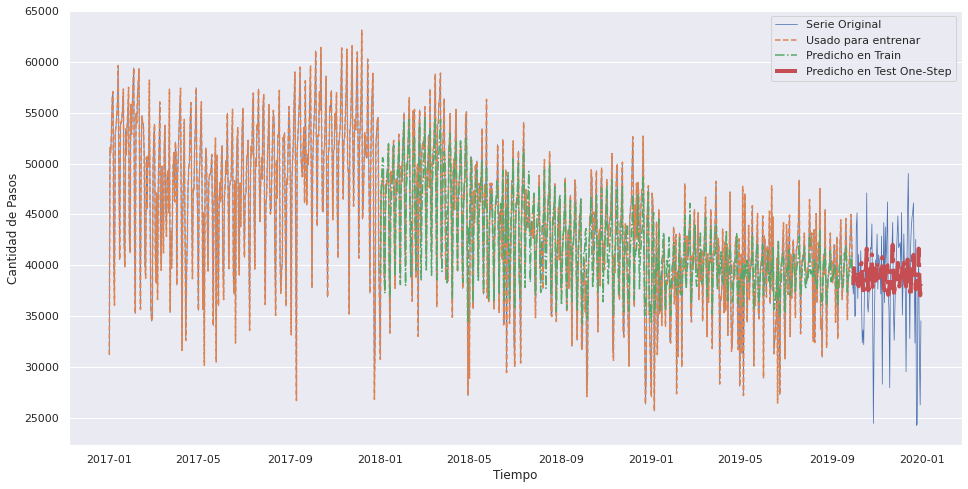

In [54]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test con el One-Step
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test One-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.grid(axis='x')
plt.show();

In [55]:
# Calculo el RMSE en train y test
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))


RMSE en Train: 3277.521219322524
RMSE en Test: 4840.2697870116135


**COMENTARIO** en este caso el RMSE del test quedo muy similar al brenchmark, la diferencia esta en que tengo menor varianza, con lo cual mi modelo no esta aprendiendo los datos de memoria, prefiero este ultimo.

**Predicción a Futuro (año 2020)**

Necesito generar todas las fechas del 2020 para poder, con el modelo elegido, realizar la prediccion del mismo. Para ello a partir del último valor de mi serie genero mediante la utilización de la función de pandas *datatime.timedelta* la siguientes fechas.

In [56]:
senial.shape

(1095,)

In [57]:
# Último día de mi serie diario
diario.index[-1]

Timestamp('2019-12-31 00:00:00', freq='D')

In [58]:
# Con esta función de panda le sumo un día.
diario.index[-1]+datetime.timedelta(days=1)

Timestamp('2020-01-01 00:00:00', freq='D')

In [59]:
# A través de un for voy a generar todo el 2020.
days_2020=[]
primerdia = diario.index[-1]+datetime.timedelta(days=1)
for i in range(0,366):
    nextday = primerdia + datetime.timedelta(days=i)
    days_2020.append(nextday)    

In [60]:
days_2020

[Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-02 00:00:00', freq='D'),
 Timestamp('2020-01-03 00:00:00', freq='D'),
 Timestamp('2020-01-04 00:00:00', freq='D'),
 Timestamp('2020-01-05 00:00:00', freq='D'),
 Timestamp('2020-01-06 00:00:00', freq='D'),
 Timestamp('2020-01-07 00:00:00', freq='D'),
 Timestamp('2020-01-08 00:00:00', freq='D'),
 Timestamp('2020-01-09 00:00:00', freq='D'),
 Timestamp('2020-01-10 00:00:00', freq='D'),
 Timestamp('2020-01-11 00:00:00', freq='D'),
 Timestamp('2020-01-12 00:00:00', freq='D'),
 Timestamp('2020-01-13 00:00:00', freq='D'),
 Timestamp('2020-01-14 00:00:00', freq='D'),
 Timestamp('2020-01-15 00:00:00', freq='D'),
 Timestamp('2020-01-16 00:00:00', freq='D'),
 Timestamp('2020-01-17 00:00:00', freq='D'),
 Timestamp('2020-01-18 00:00:00', freq='D'),
 Timestamp('2020-01-19 00:00:00', freq='D'),
 Timestamp('2020-01-20 00:00:00', freq='D'),
 Timestamp('2020-01-21 00:00:00', freq='D'),
 Timestamp('2020-01-22 00:00:00', freq='D'),
 Timestamp

In [61]:
# Transformo mi lista en una serie creando la fecha como índice
serie = pd.Series(index=days_2020)
serie

2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
              ..
2020-12-27   NaN
2020-12-28   NaN
2020-12-29   NaN
2020-12-30   NaN
2020-12-31   NaN
Length: 366, dtype: float64

In [62]:
# Por último uno el año 2020 generado a mi serie (senial)
nsenial = pd.concat([senial, serie])

In [63]:
nsenial.shape

(1461,)

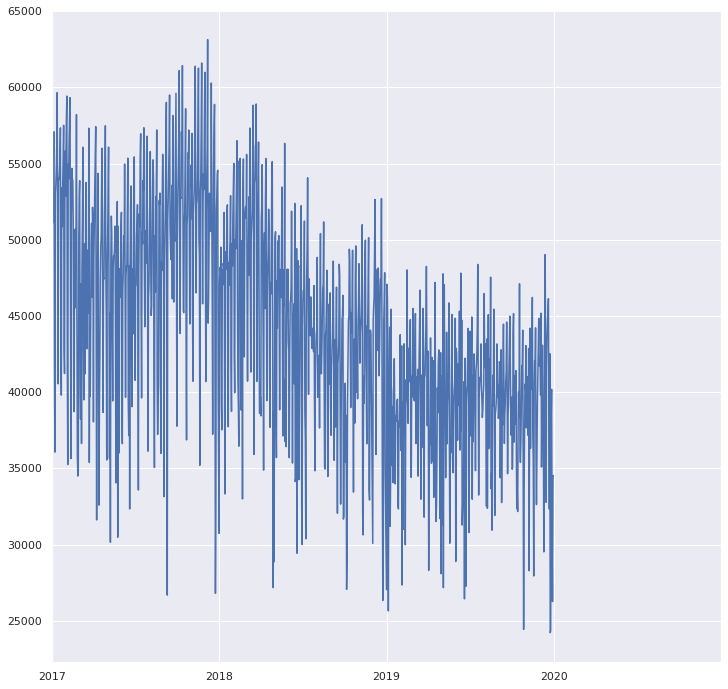

In [64]:
#Dibujo el nuevo dataset:
nsenial.plot()

In [65]:
# Creo los X e y con ceros para luego llenar con los datos con mi nuevo dataset.
N = nsenial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1095, 365) (1095,)


In [66]:
#Llenamos los X y los y
for i in range(X.shape[0]):
    X[i,:] = nsenial.iloc[i:i+look_back]
    y[i] = nsenial.iloc[i+look_back]

In [67]:
 #Definimos nuestros datos de Train y Test (Manteniendo mi look_back de 365 días)
N_train = (365*2) + (364) - look_back # cantidad de instancias que vamos a usar para entrenar. (2 años)
N_test = 366  #cantidad de puntos que vamos a usar para evaluar (1 año)
N_total = N_train + N_test
print(N_total)
length_total = N_train + N_test + look_back

print (length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

1095
1460
(729, 365) (729,)
(366, 365) (366,)


In [68]:
X_test[0,:] 

array([29840.66666667, 27038.        , 47080.        , 46194.        ,
       42887.        , 25650.        , 35546.        , 39580.        ,
       44266.        , 31199.        , 34330.        , 45439.        ,
       35187.        , 37122.        , 39057.        , 34062.        ,
       40063.        , 40492.        , 42189.        , 38084.5       ,
       33980.        , 38456.        , 38090.        , 38574.        ,
       39432.        , 39538.        , 32590.        , 32339.        ,
       38081.        , 37742.        , 39326.        , 43766.        ,
       36179.        , 38443.        , 43031.        , 27343.        ,
       39333.        , 30992.        , 39282.        , 43170.        ,
       37268.        , 40816.        , 29980.        , 39144.        ,
       39659.        , 39625.        , 48018.        , 39283.        ,
       37955.        , 42869.        , 40680.        , 42452.        ,
       43635.        , 44754.        , 35645.        , 34404.        ,
      

In [69]:
# Genero mi predicción (forecast) para el año 2020
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = xr_b.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

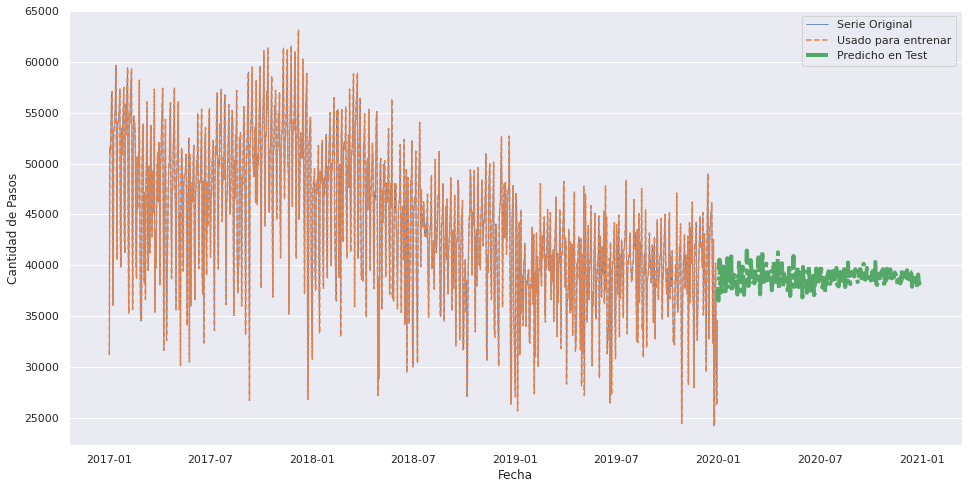

In [70]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test.
plt.figure(figsize=(16,8))
plt.plot(nsenial.index[:length_total], nsenial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(nsenial.index[:N_train + look_back], nsenial[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(nsenial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(nsenial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.grid(axis='x')
plt.show();

**COMENTARIO** La predicción que obtengo con mi modelo XGBoost para el 2020 es similar al comportamiento observado en 2019. Cuanto mayor es la información hascia atras que uno puede disponer, mejorsera la predicción. En este caso considero que con el 2019 ya logre una buena predicción del 2020.

In [71]:
serie.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=366, freq=None)

In [72]:
# Genero mi forecast para el año 2020
forecast_2020 = pd.DataFrame(y_ms_test_pred, columns=['cantidad_pasos'],  index= serie.index)



In [73]:
forecast_2020.head(10)

,cantidad_pasos
2020-01-01,37675.019531
2020-01-02,36509.703125
2020-01-03,39247.320312
2020-01-04,40544.050781
2020-01-05,37988.429688
2020-01-06,37927.074219
2020-01-07,37332.890625
2020-01-08,38724.210938
2020-01-09,39379.273438
2020-01-10,38163.277344


**PREDICCIÓN CON PROPHET**. El objetivo en este caso será utilizar esta librería para predecir 2020 y asi ver si mejora o no la predicción respecto a la anterior.

In [74]:
# Vuelvo a mi dataset original. (Con la información desde el 1/01/2017 hasta el 31/12/2019)
diario.head()

,cantidad_pasos,year,month,week,day
fecha,,,,,
2017-01-01,31183.0,2017.0,1.0,52.0,1.0
2017-01-02,51568.0,2017.0,1.0,1.0,2.0
2017-01-03,51093.0,2017.0,1.0,1.0,3.0
2017-01-04,53332.0,2017.0,1.0,1.0,4.0
2017-01-05,56486.0,2017.0,1.0,1.0,5.0


Para usar esa libreria debo replantear la serie

In [75]:
# Elimino la columna y transformo mi dataset tal cual lo requiere esta librería.
diario.drop(columns=['year','month','week','day'],inplace =True)

In [76]:
diario.head()

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0


In [77]:
#Replanteo de la serie:
df = diario.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2017-01-01,31183.0
1,2017-01-02,51568.0
2,2017-01-03,51093.0
3,2017-01-04,53332.0
4,2017-01-05,56486.0


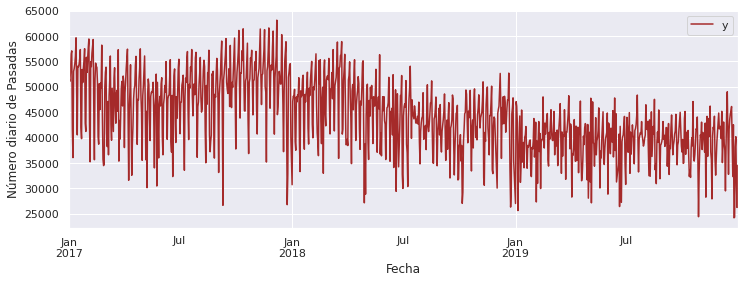

In [78]:
# Gráfico de las Pasadas Diarias
ax = df.set_index('ds').plot(figsize = (12, 4), color = 'brown')
ax.set_ylabel('Número diario de Pasadas')
ax.set_xlabel('Fecha')
plt.show();

In [79]:
# Defino mi modelo
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(df)

Para predecir los valores usando el Prophet, necesitamos crear las datos con ds(datetime stamp) que contenga las fechas para las que quiero hacer las predicciones. Mediante la utilización de *make_future_dataframe()* al cual le especifico el número de días que se extenderán hacia el futuro.

In [80]:
# Realizo mi predicción
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)

In [81]:
forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1451,2020-12-22,20451.322322,24381.768807,43700.119157,17278.598922,23283.671965,13825.905388,13825.905388,13825.905388,14131.271012,14131.271012,14131.271012,26.238452,26.238452,26.238452,-331.604077,-331.604077,-331.604077,0.0,0.0,0.0,34277.227710
1452,2020-12-23,20443.201343,25796.661658,45080.476494,17257.576505,23291.218917,15299.336272,15299.336272,15299.336272,14131.271012,14131.271012,14131.271012,1837.521858,1837.521858,1837.521858,-669.456598,-669.456598,-669.456598,0.0,0.0,0.0,35742.537615
1453,2020-12-24,20435.080363,27523.304201,45456.418568,17236.554088,23298.765868,16347.960205,16347.960205,16347.960205,14131.271012,14131.271012,14131.271012,3208.776721,3208.776721,3208.776721,-992.087528,-992.087528,-992.087528,0.0,0.0,0.0,36783.040568
1454,2020-12-25,20426.959383,28835.149060,47445.491053,17215.531671,23306.312819,18015.884969,18015.884969,18015.884969,14131.271012,14131.271012,14131.271012,5179.848873,5179.848873,5179.848873,-1295.234916,-1295.234916,-1295.234916,0.0,0.0,0.0,38442.844352
1455,2020-12-26,20418.838403,21618.935649,39763.784286,17194.509254,23314.184248,10092.301194,10092.301194,10092.301194,14131.271012,14131.271012,14131.271012,-2463.950334,-2463.950334,-2463.950334,-1575.019484,-1575.019484,-1575.019484,0.0,0.0,0.0,30511.139597
1456,2020-12-27,20410.717423,16897.507434,35505.699061,17173.405915,23322.331678,5587.875945,5587.875945,5587.875945,14131.271012,14131.271012,14131.271012,-6715.380197,-6715.380197,-6715.380197,-1828.014870,-1828.014870,-1828.014870,0.0,0.0,0.0,25998.593368
1457,2020-12-28,20402.596443,21962.745264,40842.149258,17152.299752,23330.479107,11006.908593,11006.908593,11006.908593,14131.271012,14131.271012,14131.271012,-1073.055373,-1073.055373,-1073.055373,-2051.307047,-2051.307047,-2051.307047,0.0,0.0,0.0,31409.505036
1458,2020-12-29,20394.475464,22622.489599,40910.021013,17131.193588,23336.611520,11914.967695,11914.967695,11914.967695,14131.271012,14131.271012,14131.271012,26.238452,26.238452,26.238452,-2242.541769,-2242.541769,-2242.541769,0.0,0.0,0.0,32309.443159
1459,2020-12-30,20386.354484,24800.512198,43076.469065,17110.087425,23340.379746,13568.833666,13568.833666,13568.833666,14131.271012,14131.271012,14131.271012,1837.521858,1837.521858,1837.521858,-2399.959204,-2399.959204,-2399.959204,0.0,0.0,0.0,33955.188150
1460,2020-12-31,20378.233504,26346.652901,44224.715557,17086.291323,23343.228930,14817.632517,14817.632517,14817.632517,14131.271012,14131.271012,14131.271012,3208.776721,3208.776721,3208.776721,-2522.415216,-2522.415216,-2522.415216,0.0,0.0,0.0,35195.866021


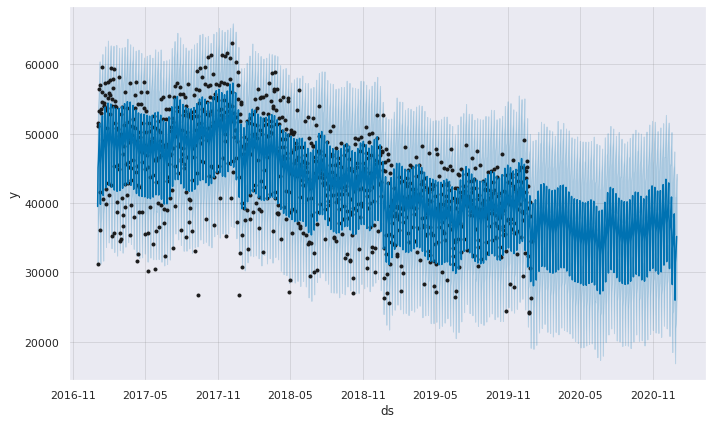

In [82]:
# Realizamos el gráfico de mi Forecast
m.plot(forecast);

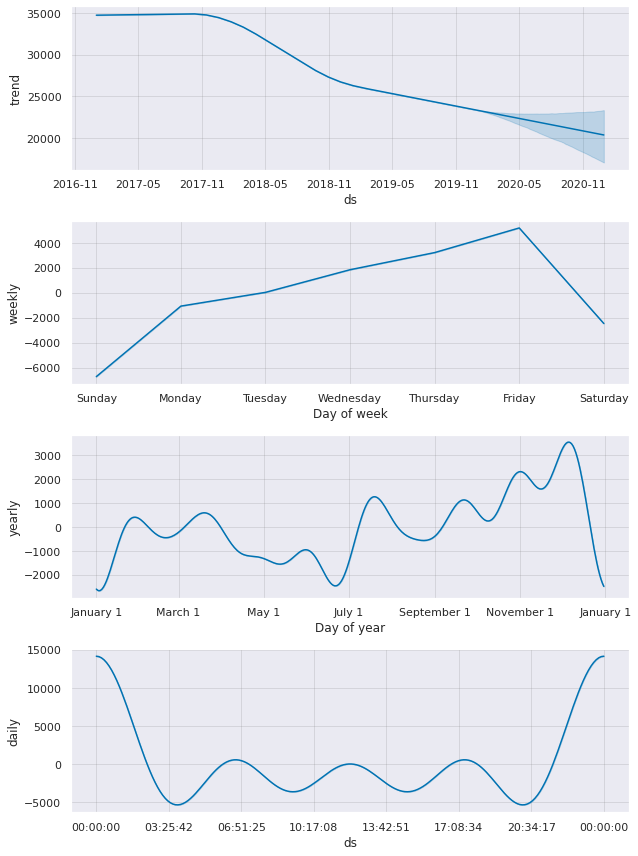

In [83]:
#Grafico los componentes del forecast:
m.plot_components(forecast);

In [84]:
# Predicción con Prophet para fechas específicas
print(forecast[forecast.ds=='2020-04-10'].yhat)
forecast[forecast.ds=='2020-10-10'].yhat

1195    40958.71554
Name: yhat, dtype: float64


1378    32971.95225
Name: yhat, dtype: float64

In [85]:
# Predicción con mi modelo entrenado con XGboost para fechas específicas
print(forecast_2020.loc['2020-04-10 00:00:00'])
forecast_2020.loc['2020-10-10 00:00:00']

cantidad_pasos    40464.375
Name: 2020-04-10 00:00:00, dtype: float32


cantidad_pasos    40319.0
Name: 2020-10-10 00:00:00, dtype: float32

**COMENTARIO:** en las dos ejecuciones de arriba imprimo la predicción obtenida primero con Prophet y luego con mi modelo de XGboost entrenado para los mismas fechas del 2020 y se puede observar que al principio del 2020 (las primeras predicciones no están tan separadas) pero a medida que avanza el año la predicción con Prophet disminuye tal cual se veía en la tendencia pero en el caso del modelo predecido con XGboost la misma no decrece tanto y esto es tal cual muestra el grafico de la predicción con XGboost donde se visualiza que la predicción se mantiene oscilante alrededor de los 40000.

**INVESTIGACIÓN:**

Trabajar solo con tipo de vehículo "liviano", puesto que claramente son mayoritarios en el flujo vehicular y el transporte "pesado" no tiene el mismo comportamiento. Tambien podria trabajar con los tipos de vehiculos modelados por separado.
Incluir más features para definir mi modelo y generar así nuevamente las predicciones para el último trimeste del 2019 y todo el 2020.
Optimizar el modelo obtenido con Prophet buscando los mejores hiperparametros para ello deberé investigar cuales son y como se realiza la optimización con dicha librería.

**Para pensar, investigar y, opcionalmete, implementar**

Comparación de las series (2017, 2018 y 2019) entre los distintos peajes según forma de pago, solo tendré en cuenta como forma de pago Efectivo y Telepase.


In [86]:
data_2019 = pd.read_csv('/content/drive/MyDrive/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/drive/MyDrive/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/content/drive/MyDrive/flujo-vehicular-2017.csv', sep =',')

In [87]:
#Unimos los 3 datasets y lo hacemos directamente ya que tienen las mismas columnas
data = pd.concat([data_2019, data_2018, data_2017])

In [88]:
data.shape

(3560706, 10)

In [89]:
data.forma_pago.value_counts()

TELEPASE                1027861
EFECTIVO                1020176
EXENTO                   464708
INFRACCION               405034
NO COBRADO               380450
TARJETA DISCAPACIDAD     186454
T. DISCAPACIDAD           76001
MONEDERO                     14
Otros                         8
Name: forma_pago, dtype: int64

In [90]:
#Me quedo solamente con la forma de pago 'TELEPASE' y 'EFECTIVO'
mask = np.logical_or(data.forma_pago == 'EFECTIVO', data.forma_pago == 'TELEPASE')
data = data[mask]

#Quito las columnas que no voy a utilizar
data.drop(columns = ['periodo','hora_inicio'], inplace = True)

#Paso la columna fecha a formato datetime, y le uno la hora_fin como hora
data['fecha2'] = pd.to_datetime(data.fecha) + pd.to_timedelta(data.hora_fin, unit = 'h')

#Quito las columnas fecha y hora_fin ya que las incluí en el campo fecha2
data.drop(columns=['fecha','hora_fin'], inplace = True)

#Correjo el nombre de fecha2 a fecha
data.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordeno el dataset por fecha
data.sort_values('fecha', inplace = True);
data.reset_index(drop=True, inplace = True)
data.head(15)

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,Domingo,Dellepiane Liniers,Provincia,Pesado,TELEPASE,4,2017-01-01
1,Domingo,Avellaneda,Provincia,Pesado,TELEPASE,5,2017-01-01
2,Domingo,Avellaneda,Provincia,Pesado,EFECTIVO,7,2017-01-01
3,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,17,2017-01-01
4,Domingo,Avellaneda,Provincia,Pesado,TELEPASE,3,2017-01-01
5,Domingo,Avellaneda,Provincia,Pesado,TELEPASE,13,2017-01-01
6,Domingo,Avellaneda,Provincia,Pesado,EFECTIVO,13,2017-01-01
7,Domingo,Avellaneda,Provincia,Pesado,TELEPASE,17,2017-01-01
8,Domingo,Avellaneda,Provincia,Pesado,EFECTIVO,21,2017-01-01
9,Domingo,Dellepiane Liniers,Provincia,Pesado,EFECTIVO,16,2017-01-01


In [91]:
data.shape

(2048037, 7)

In [92]:
# Para poder realizar un mejor análisis y estudio de la serie por año creo la columna año
data['year']= data.fecha.dt.year

In [93]:
# Verifico las estaciones de peajes
data.estacion.unique()

array(['Dellepiane Liniers', 'Avellaneda', 'Sarmiento', 'Alberdi',
       'Illia', 'Dellepiane Centro', 'Retiro', 'Salguero', 'Dellepiane',
       'Alberti', 'PDB'], dtype=object)

In [94]:
# Unifico la estaciones Dellepiane Liniers, Centro todas en Dellepiane.
data.estacion=data.estacion.replace('Dellepiane Centro', 'Dellepiane')
data.estacion=data.estacion.replace('Dellepiane Liniers', 'Dellepiane')
data.estacion.unique()

array(['Dellepiane', 'Avellaneda', 'Sarmiento', 'Alberdi', 'Illia',
       'Retiro', 'Salguero', 'Alberti', 'PDB'], dtype=object)

In [95]:
# Reemplazo la estacion Alberdi por Alberti
data.estacion=data.estacion.replace('Alberti','Alberdi')

In [96]:
# Analizo la cantidad de pasadas por estacion de peaje
data.estacion.value_counts()

Avellaneda    540829
Dellepiane    501508
Illia         443481
Retiro        233885
Alberdi       216416
Salguero       46600
Sarmiento      44865
PDB            20453
Name: estacion, dtype: int64

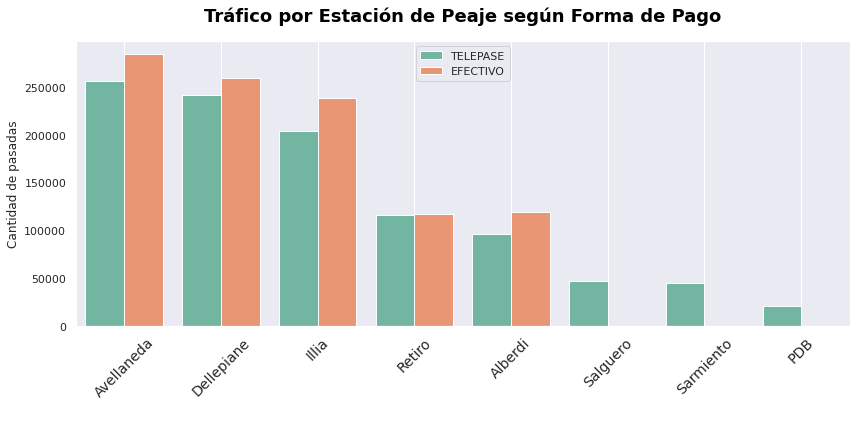

In [97]:
# Grafico la cantidad de pasadas por estacion teniendo en cuanta la forma de pago
#--------------------------------------------------------------------------------
plt.figure(figsize=(12,6))
ax = sns.countplot(x='estacion',
                   data=data, order=data['estacion'].value_counts().index, hue='forma_pago', palette= 'Set2')

ax.set_xticklabels(ax.get_xticklabels(), fontsize= 14, rotation=45)
plt.ylabel('Cantidad de pasadas')
plt.xlabel('  ')
plt.title('Tráfico por Estación de Peaje según Forma de Pago', pad= 20, fontdict = title_font )
plt.grid()
plt.legend()
plt.tight_layout()
plt.show();

**COMENTARIO** puede observarse que en las estaciones Avellaneda, Dellepiane, Illia, Retiro y Alberdi, la forma de pado Efectivo y Telepeaje es casi igual en cantidad, mientras que eb Salguero, Sarmiento y PDB es en su totalidad Telepeaje. Esto estaría evidenciando esa tendencia decreciente que observabamos en los graficos anteriores en el flujo vehicular pago efectivo.